In [1]:
# ============================================================
# HEART ATTACK DATASET PROJECT (KNN + NEURAL NETWORK)
# ============================================================

import os
import zipfile
import glob
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
from sklearn.neighbors import KNeighborsClassifier

import matplotlib.pyplot as plt


In [2]:
# ============================================================
# 1. DOWNLOAD DATASET USING KAGGLEHUB
# ============================================================
print("Downloading dataset...")

import kagglehub
path = kagglehub.dataset_download("sukhmandeepsinghbrar/heart-attack-dataset")
print("Downloaded path:", path)


# ============================================================
# 2. FIND AND READ CSV FILE
# ============================================================
csv_file = None
candidates = glob.glob(os.path.join(path, "*.csv"))
if not candidates:
    candidates = glob.glob(os.path.join(path, "**", "*.csv"), recursive=True)

if not candidates:
    raise FileNotFoundError("CSV not found inside dataset folder!")

csv_file = candidates[0]
print("CSV File:", csv_file)

df = pd.read_csv(csv_file)
print("\nDataset Loaded. Shape =", df.shape)
df.head()


100%|██████████| 15.9k/15.9k [00:00<00:00, 21.6MB/s]

Extracting files...
Downloaded path: /root/.cache/kagglehub/datasets/sukhmandeepsinghbrar/heart-attack-dataset/versions/1
CSV File: /root/.cache/kagglehub/datasets/sukhmandeepsinghbrar/heart-attack-dataset/versions/1/Medicaldataset.csv

Dataset Loaded. Shape = (1319, 9)


,Age,Gender,Heart rate,Systolic blood pressure,Diastolic blood pressure,Blood sugar,CK-MB,Troponin,Result
0,63,1,66,160,83,160.0,1.80,0.012,negative
1,20,1,94,98,46,296.0,6.75,1.060,positive
2,56,1,64,160,77,270.0,1.99,0.003,negative
3,66,1,70,120,55,270.0,13.87,0.122,positive
4,54,1,64,112,65,300.0,1.08,0.003,negative


In [3]:
# ============================================================
# 3. MAP TARGET COLUMN: positive/negative -> 1/0
# ============================================================
def map_label(v):
    s = str(v).lower().strip()
    if "pos" in s: return 1
    if "neg" in s: return 0
    try:
        return 1 if float(s) > 0.5 else 0
    except:
        return 0

df["Target"] = df["Result"].apply(map_label)
y = df["Target"].astype(int)


In [4]:
# ============================================================
# 4. FEATURE SELECTION - Select Best 5 Features
# ============================================================
X = df.drop(columns=["Result","Target"])
X = X.apply(pd.to_numeric, errors="coerce").fillna(X.median())

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

selector = SelectKBest(score_func=f_classif, k=5)
selector.fit(X_scaled, y)

selected_features = list(X.columns[selector.get_support()])
print("\nTop 5 Selected Features =", selected_features)

X_sel = X[selected_features]



Top 5 Selected Features = ['Age', 'Gender', 'Blood sugar', 'CK-MB', 'Troponin']


In [5]:
# ============================================================
# 5. TRAIN-TEST SPLIT + STANDARD SCALING
# ============================================================
X_train, X_test, y_train, y_test = train_test_split(
    X_sel, y, test_size=0.2, random_state=42, stratify=y
)

std = StandardScaler()
X_train = std.fit_transform(X_train)
X_test = std.transform(X_test)


In [6]:
# ============================================================
# 6. KNN CLASSIFIER
# ============================================================
print("\n================ KNN CLASSIFIER ================")

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)
y_prob_knn = knn.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred_knn))
print("KNN ROC-AUC:", roc_auc_score(y_test, y_prob_knn))

train_acc_knn = accuracy_score(y_train, knn.predict(X_train))
test_acc_knn = accuracy_score(y_test, y_pred_knn)

print("\nKNN Training Accuracy:", train_acc_knn)
print("KNN Testing Accuracy :", test_acc_knn)



================ KNN CLASSIFIER ================
              precision    recall  f1-score   support

           0       0.66      0.78      0.72       102
           1       0.85      0.75      0.79       162

    accuracy                           0.76       264
   macro avg       0.75      0.77      0.76       264
weighted avg       0.77      0.76      0.76       264

KNN ROC-AUC: 0.8517610748002904

KNN Training Accuracy: 0.7990521327014218
KNN Testing Accuracy : 0.7613636363636364


In [7]:
# ============================================================
# 7. NEURAL NETWORK (4-LAYER MLP)
# ============================================================
print("\n================ NEURAL NETWORK ================")

import tensorflow as tf
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(16, activation="relu"),
    layers.Dense(8, activation="relu"),
    layers.Dense(4, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

history = model.fit(X_train, y_train, epochs=40, batch_size=8,
                    validation_split=0.2, verbose=1)

loss, acc = model.evaluate(X_test, y_test, verbose=0)
print("\nNeural Network Accuracy:", acc)

y_prob_nn = model.predict(X_test).ravel()
y_pred_nn = (y_prob_nn >= 0.5).astype(int)

print("\nNN CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred_nn))



================ NEURAL NETWORK ================


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 273 (1.07 KB)

 Trainable params: 273 (1.07 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5273 - loss: 0.6956 - val_accuracy: 0.6209 - val_loss: 0.6863
Epoch 2/40
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6398 - loss: 0.6825 - val_accuracy: 0.6351 - val_loss: 0.6699
Epoch 3/40
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6698 - loss: 0.6503 - val_accuracy: 0.6493 - val_loss: 0.6302
Epoch 4/40
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6651 - loss: 0.6038 - val_accuracy: 0.6635 - val_loss: 0.6086
Epoch 5/40
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7119 - loss: 0.5623 - val_accuracy: 0.7109 - val_loss: 0.5916
Epoch 6/40
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7557 - loss: 0.5185 - val_accuracy: 0.7062 - val_loss: 0.5807
Epoch 7/40
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7918 - loss: 0.4631 - val_accuracy: 0.7393 - val_loss: 0.5714
Epoch 8/40
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7854 - loss: 0.4578 - val_accuracy: 0.

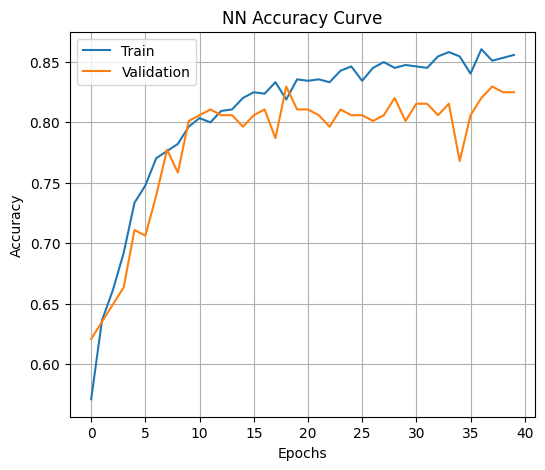

In [8]:
plt.figure(figsize=(6,5))
plt.plot(history.history["accuracy"], label="Train")
plt.plot(history.history["val_accuracy"], label="Validation")
plt.title("NN Accuracy Curve")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()



=== CONFUSION MATRIX ===


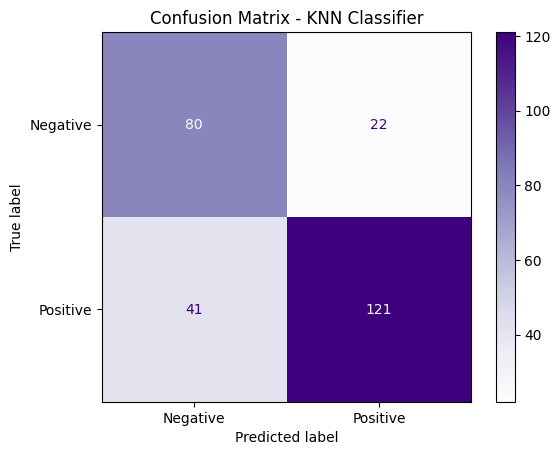

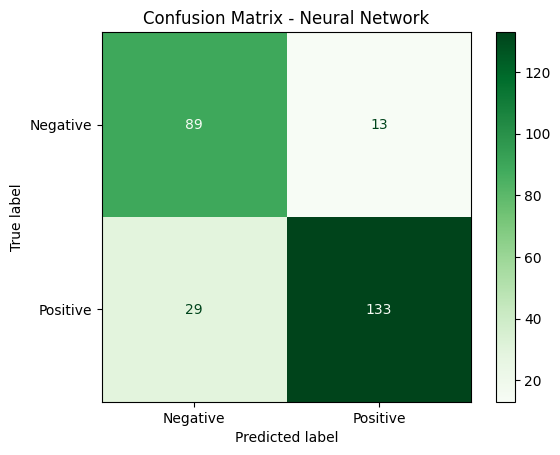

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

print("\n=== CONFUSION MATRIX ===")

# KNN Confusion Matrix
cm_knn = confusion_matrix(y_test, y_pred_knn)
disp_knn = ConfusionMatrixDisplay(confusion_matrix=cm_knn,
                                 display_labels=["Negative", "Positive"])
disp_knn.plot(cmap="Purples", values_format="d")
plt.title("Confusion Matrix - KNN Classifier")
plt.show()

# Neural Network Confusion Matrix
cm_nn = confusion_matrix(y_test, y_pred_nn)
disp_nn = ConfusionMatrixDisplay(confusion_matrix=cm_nn,
                                display_labels=["Negative", "Positive"])
disp_nn.plot(cmap="Greens", values_format="d")
plt.title("Confusion Matrix - Neural Network")
plt.show()


In [14]:
print("\n============= RANDOM TEST SAMPLE =============")

idx = np.random.randint(0, len(X_test))
x_sample = X_test[idx].reshape(1, -1)
actual = y_test.iloc[idx]

print("\nActual:", "Positive" if actual==1 else "Negative")
print("Feature Values:")
for f, v in zip(selected_features, X_test[idx]):
    print(f"{f}: {v}")

# KNN Prediction
prob_k = knn.predict_proba(x_sample)[0][1]
print("\nKNN →", "Positive" if prob_k>=0.5 else "Negative", " (Prob:", prob_k,")")

# NN Prediction
prob_n = model.predict(x_sample)[0][0]
print("NN →", "Positive" if prob_n>=0.5 else "Negative", " (Prob:", prob_n,")")

print("\nRandom Test Prediction Done!")



============= RANDOM TEST SAMPLE =============

Actual: Negative
Feature Values:
Age: -0.2322267387076789
Gender: 0.7242696141551427
Blood sugar: 2.672452821170014
CK-MB: -0.19850124449806755
Troponin: -0.3153008818011822

KNN → Negative  (Prob: 0.4 )
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
NN → Positive  (Prob: 0.5466897 )

Random Test Prediction Done!
